In [1]:
import html
import pandas as pd

In [2]:
import geopandas as gpd

In [3]:
import os

In [4]:
from math import ceil

In [ ]:
# https://resultados.tse.jus.br/oficial/ele2022/546/dados/sp/sp61018-c0003-e000546-v.json

In [ ]:
# Documentação
# https://www.justicaeleitoral.jus.br/++theme++justica_eleitoral/pdfjs/web/viewer.html?file=https://www.justicaeleitoral.jus.br/arquivos/instrucoes-para-download-dos-arquivos-da-divulgacao-2018-versao-1-1/@@download/file/instrucoes-para-download-dos-arquivos-da-divulgacao-2018-versao-1-1.pdf

In [5]:
os.chdir('C:\\Users\\rgarcia\\Documents\\Data')

In [27]:
# retira lista de nomes de candidatos a governador

cands = pd.read_json('https://resultados.tse.jus.br/oficial/ele2022/546/dados/sp/sp-c0003-e000546-006-f.json').loc['agr', 'carg']
cand_nums = pd.json_normalize(pd.json_normalize(pd.json_normalize(pd.json_normalize(pd.json_normalize(cands, max_level=0)['par'])[0])['cand'])[0])
cand_nums = cand_nums[['n', 'nmu']].dropna()
cand_nums['nmu'] = cand_nums.nmu.apply(lambda x: html.unescape(x).title())
cand_dict = dict(zip(cand_nums.n.to_list(), cand_nums.nmu.to_list()))

In [28]:
cand_dict

{'29': 'Edson Dorta',
 '10': 'Tarcísio',
 '21': 'Gabriel Colombo',
 '12': 'Elvis Cezar',
 '16': 'Altino',
 '30': 'Vinicius Poit',
 '45': 'Rodrigo Garcia',
 '80': 'Carol Vigliar',
 '13': 'Fernando Haddad',
 '27': 'Antonio Jorge'}

In [7]:
# gera lista de códigos de municipios para injetar no JSON

cod_mun = pd.read_csv('https://raw.githubusercontent.com/rafagarc/eleicoes_2022/main/mapas_1o_turno/codigos_IBGE_TSE.csv')
cod_mun['codigo_tse'] = cod_mun.codigo_tse.astype(str).str.zfill(5)
muns = cod_mun.codigo_tse.to_list()
cod_mun['uf'] = cod_mun.uf.str.lower()
list_mun = cod_mun['uf'].astype(str) + cod_mun['codigo_tse'].astype(str).to_list()

In [11]:
# filtra só são paulo

list_mun = [i for i  in list_mun if i[0:2] == 'sp']

In [23]:
# gera chassi para concatenar a tabela
munvotes = pd.DataFrame(columns=['muncod', '27', '10', '45', '80', '21', '16', '30', '29', '12', '13'])

In [24]:
for i in list_mun:
    raw_data = pd.read_json(f'https://resultados.tse.jus.br/oficial/ele2022/546/dados/sp/{i}-c0003-e000546-v.json')
    raw_mun = pd.json_normalize(raw_data['abr']).query('tpabr == "MU"')['cand']
    mun = pd.json_normalize(pd.json_normalize(raw_mun).T[0])
    mun = mun[['n', 'vap']].T
    mun.columns = mun.loc['n']
    mun = mun.drop('n')
    mun.insert(loc=0, column='muncod', value=[i])
    munvotes = pd.concat([munvotes,mun])

In [25]:
munvotes

,muncod,27,10,45,80,21,16,30,29,12,13
vap,sp61018,5,11940,2496,25,23,7,149,5,104,3337
vap,sp61034,0,1353,956,2,1,0,5,0,12,561
vap,sp61050,2,6903,3572,25,32,7,102,2,94,4396
vap,sp61131,4,9896,5508,38,25,5,219,0,122,4377
vap,sp61581,0,1538,1158,0,2,0,10,0,13,810
...,...,...,...,...,...,...,...,...,...,...,...
vap,sp61115,1,1529,628,5,7,3,31,2,12,724
vap,sp61239,0,1291,731,2,5,1,9,0,4,569
vap,sp61255,2,5792,3909,24,9,2,60,3,42,3360
vap,sp61271,0,650,634,2,3,0,4,0,23,629


In [29]:
munvotes.columns = [cand_dict[i] if i in cand_dict.keys() else i for i in munvotes.columns]

In [30]:
munvotes.to_csv('munvotes_governador.csv', index=False)

In [31]:
munvotes = munvotes.set_index('muncod')

In [32]:
munvotes = munvotes.astype('int32')

In [35]:
munvotes['TOTAL'] = munvotes.sum(axis=1)

In [38]:
munvotes_pct = (munvotes.drop(columns='TOTAL').div(munvotes.TOTAL, axis=0)*100).round(2)

In [39]:
munvotes_pct['Tarcísio - Haddad (%)'] = (munvotes_pct['Tarcísio']-munvotes_pct['Fernando Haddad']).round(2)

In [40]:
munvotes_pct['Votos válidos'] = munvotes.TOTAL

In [41]:
tse_codes = munvotes_pct.index.to_series().apply(lambda x: int(x[-5:]))

In [42]:
munvotes_pct.insert(loc=0, column='codigo_tse', value=tse_codes)

In [43]:
munvotes_pct

,codigo_tse,Antonio Jorge,Tarcísio,Rodrigo Garcia,Carol Vigliar,Gabriel Colombo,Altino,Vinicius Poit,Edson Dorta,Elvis Cezar,Fernando Haddad,Tarcísio - Haddad (%),Votos válidos
muncod,,,,,,,,,,,,,
sp61018,61018,0.03,66.00,13.80,0.14,0.13,0.04,0.82,0.03,0.57,18.45,47.55,18091
sp61034,61034,0.00,46.82,33.08,0.07,0.03,0.00,0.17,0.00,0.42,19.41,27.41,2890
sp61050,61050,0.01,45.61,23.60,0.17,0.21,0.05,0.67,0.01,0.62,29.05,16.56,15135
sp61131,61131,0.02,49.00,27.28,0.19,0.12,0.02,1.08,0.00,0.60,21.67,27.33,20194
sp61581,61581,0.00,43.56,32.80,0.00,0.06,0.00,0.28,0.00,0.37,22.94,20.62,3531
...,...,...,...,...,...,...,...,...,...,...,...,...,...
sp61115,61115,0.03,51.97,21.35,0.17,0.24,0.10,1.05,0.07,0.41,24.61,27.36,2942
sp61239,61239,0.00,49.43,27.99,0.08,0.19,0.04,0.34,0.00,0.15,21.78,27.65,2612
sp61255,61255,0.02,43.87,29.61,0.18,0.07,0.02,0.45,0.02,0.32,25.45,18.42,13203


In [44]:
tse_ibge = pd.read_csv('https://raw.githubusercontent.com/rafagarc/eleicoes_2022/main/mapas_1o_turno/codigos_IBGE_TSE.csv')

In [45]:
munvotes_agg = tse_ibge.merge(munvotes_pct, how='left', on='codigo_tse')

In [46]:
munvotes_agg['codigo_ibge'] = munvotes_agg.codigo_ibge.astype(str)

In [47]:
munmap = gpd.read_file('BR_Municipios_2021_low_res.json')

In [48]:
munmap = munmap.rename(columns={'CD_MUN':'codigo_ibge'})

In [49]:
votemap = munmap.merge(munvotes_agg, on='codigo_ibge', how='left')

In [63]:
legbound = ceil(max((votemap['Tarcísio - Haddad (%)'].min()*-1, votemap['Tarcísio - Haddad (%)'].max())))

In [64]:
votemap=votemap[votemap.codigo_ibge.str.startswith('35')]

<AxesSubplot:>

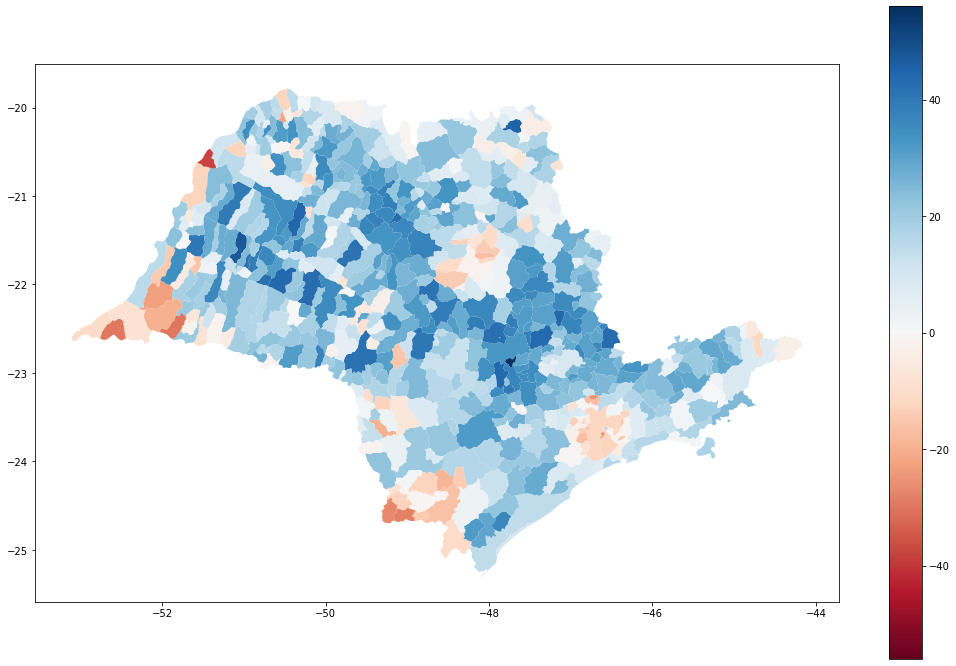

In [65]:
votemap.plot(figsize=(18,12), column='Tarcísio - Haddad (%)', cmap='RdBu', legend=True, vmin=-legbound, vmax=legbound)

In [59]:
votemap

,codigo_ibge,NM_MUN,SIGLA,AREA_KM2,geometry,codigo_tse,uf,MUNICÍPIO,capital,Antonio Jorge,...,Rodrigo Garcia,Carol Vigliar,Gabriel Colombo,Altino,Vinicius Poit,Edson Dorta,Elvis Cezar,Fernando Haddad,Tarcísio - Haddad (%),Votos válidos
3267,3500105,Adamantina,SP,411.987,"POLYGON ((-50.99301 -21.43711, -51.02585 -21.4...",61018.0,SP,ADAMANTINA,0.0,0.03,...,13.80,0.14,0.13,0.04,0.82,0.03,0.57,18.45,47.55,18091.0
3268,3500204,Adolfo,SP,211.055,"POLYGON ((-49.57243 -21.27111, -49.59711 -21.2...",61034.0,SP,ADOLFO,0.0,0.00,...,33.08,0.07,0.03,0.00,0.17,0.00,0.42,19.41,27.41,2890.0
3269,3500303,Aguaí,SP,474.554,"POLYGON ((-46.93973 -21.97809, -46.96211 -21.9...",61050.0,SP,AGUAÍ,0.0,0.01,...,23.60,0.17,0.21,0.05,0.67,0.01,0.62,29.05,16.56,15135.0
3270,3500402,Águas da Prata,SP,142.673,"POLYGON ((-46.69071 -21.83763, -46.70517 -21.8...",61077.0,SP,ÁGUAS DA PRATA,0.0,0.02,...,20.78,0.12,0.24,0.10,0.71,0.00,0.59,29.12,19.19,4210.0
3271,3500501,Águas de Lindóia,SP,60.126,"POLYGON ((-46.54986 -22.46955, -46.55481 -22.4...",61093.0,SP,ÁGUAS DE LINDÓIA,0.0,0.02,...,18.87,0.17,0.09,0.01,1.16,0.01,0.59,21.33,36.42,9905.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3907,3557006,Votorantim,SP,184.186,"POLYGON ((-47.30746 -23.56101, -47.35432 -23.5...",72435.0,SP,VOTORANTIM,0.0,0.04,...,13.98,0.33,0.18,0.03,1.36,0.01,0.77,33.74,15.82,62294.0
3908,3557105,Votuporanga,SP,420.703,"POLYGON ((-50.00751 -20.33182, -50.03732 -20.3...",72451.0,SP,VOTUPORANGA,0.0,0.01,...,22.25,0.17,0.10,0.02,0.82,0.01,0.33,22.07,32.15,48970.0
3909,3557154,Zacarias,SP,319.056,"POLYGON ((-49.96007 -21.13312, -49.99693 -21.0...",61921.0,SP,ZACARIAS,0.0,0.00,...,37.20,0.00,0.00,0.00,0.17,0.00,0.12,25.48,11.55,1715.0
3910,3557204,Chavantes,SP,188.727,"POLYGON ((-49.67729 -23.00875, -49.68644 -22.9...",63371.0,SP,CHAVANTES,0.0,0.00,...,19.17,0.25,0.16,0.11,0.57,0.00,0.54,28.99,21.24,6355.0


In [66]:
from time import sleep

In [67]:
for i in list(range(10)):
    print(i)
    sleep(1)

0
1
2
3
4
5
6
7
8
9
